# **📌 Battery Modelling - EDF R&D 2025**
### **🔋 Project Overview**
##### - **Team Members:** Hugo Tran, Etienne Guegan, Akira Kuroda, Tianhe Li
##### - **Goal:** Analyze battery ageing and impedance increase over cycles.  
##### - **Data:** Battery cell voltage, current, and test cycles.  

### **📊 Key Analysis Steps:**
##### - Load battery test data 📂
##### - Compute Capacity (Ah), SoC (%), SoH (%)
##### - Fit **OCV** vs. **SoC** Curve 📈
##### - Visualize degradation trends 🛠️

### **🔎 Context**
This project focuses on simulating and analyzing battery behavior under various conditions using different modeling approaches. It includes implementations for calculating State of Charge (SoC) and State of Health (SoH), along with zero-order and first-order RC (Resistor-Capacitor) equivalent circuit models to better understand battery dynamics.

### How to Run the Code

#### 1. Import the dataset

In [5]:
import data as dt
import plot as pt


#### 2. Import the necessary libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import cumulative_trapezoid


### <ins>File Structure</ins>

Our code is organized in multiple parts, regrouped in diverse files. \
Firstly, the file ***data.py*** regroups all the data initialization the models need to be generated.
Secondly, the file ***plot.py*** regroups all plotting function we have elaborated.
Finally, the ***main.py*** file is runs all the important functions in order to model the cell we'd like to analyze.


---
## **Description of approach and the models used**

We are tasked to simulate the battery cells' behaviour as their SoC and SoH changes over time. 


We observed that the data given of cell C and D contains the total time, current, voltage and step. We decided to plot the current, voltage and step in function of the time elapsed.

We made a function ```plot_test(cell, test)``` that takes two arguments (both in ```String```). Here is the plot of cell D with test 9:

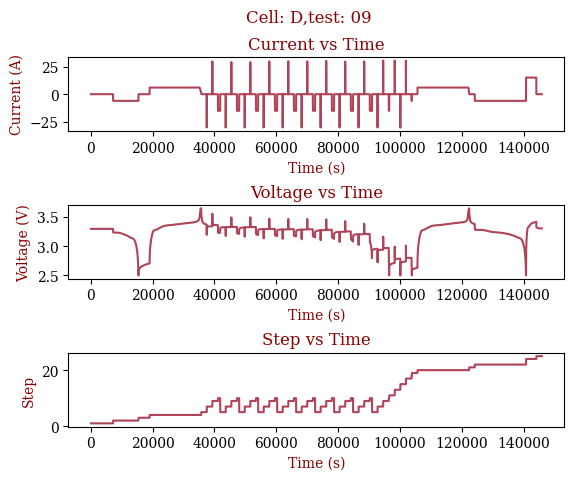

In [23]:
pt.plot_test("D", "09")


We get the following result:

<div align = "center">
    <img src = "img/data_cell_d_test_09.png" alt = "Data plot of Test 9 of Cell D in function of the total time" width = "900"/>
</div>

### **EMC of order zero (Rint Model)**
Since we need to simulate an electrical model of the cell based on ECM that is a function of the SoC and SoH, we need to determine its output voltage $U_L$.

At the beginning, we used the Rint Model to study the battery (0th order model). 

<div align = "center">
<img src = "img/circuit_zero_order.png" alt = "0th order / Rint Model circit" width = "500"/>
</div>

Its equation of $U_L$ is:


$$
U_L = U_{OC} - U_0
\implies U_L = U_{OC} - I_L \cdot R_{0}
$$


It is a simple approach to get the output voltage, since we just need to calculate the $U_{OC}$ and the internal resistance $R_0$.

### **EMC of first order (Thevenin Model)**
After finding the output voltage of the Rint Model, we decided to go further and study the battery as a 1st order ECM by using Thevenin's Model.

This approach, despite being complex than its counterpart, allows for more accuracy.

<div align = "center">
<img src = "img/circuit_first_order.png" alt = "1st order / Thevenin Model circit" width = "500"/>
</div>

From the resource given, its equation for $U_L$ is:

$$
U_L(t) = U_{OC} - I_L \cdot R_0 - I_L \cdot R_1 \cdot (1 - e^{-\frac{t}{\tau_1}})
$$

where

$$
\tau_1 = R_1 \cdot C_1
$$


This time, $U_L$ depends on $U_{OC}$, $R_0$, $R_1$ and $\tau_1$.


---
## **SoC and SoH Plots** 

### <ins>Capacity Definition</ins>
The **capacity** of a battery, measured in **Ampere-hours (Ah)**, represents the total charge it can store and deliver.  
With ageing, the available capacity decreases, meaning an older battery holds less charge than a new one.

The capacity during a **full discharge** cycle is calculated as the integral of the **current** over time:

$$
Q_{\text{remaining}} = \int_{full \: discharge} I(t) \, dt
$$

where:
- ***$Q_{remaining}$*** is the remaining charge in **Ah**,
- ***I(t)*** is the discharge current at time \( t \).

## **State of Charge** (SoC)

### <ins>Definition</ins>
The **State of Charge (SoC)** of a battery, expressed as a **percentage (%),** represents the available charge relative to its remaining capacity.
As a battery discharges, its **SoC decreases**, indicating how much charge is left compared to its *initial* full capacity.

The SoC at a given time is calculated as the ratio of the available charge to the remaining capacity:

$$
\text{SoC}(t) = \frac{Q_{\text{available(t)}}}{Q_{\text{remaining}}} \times 100
$$

where:  
- ***SoC(t)*** is the **State of Charge** at time \( t \) in **%**,  
- ***$Q_{available}$*** is the available charge in **Ah** of the remaining total,  
- ***$Q_{remaining}$*** is the remaining (rated) capacity of the battery in **Ah**.

 In our SoC calculations, we integrated the current displayed during the tests provided in order to get the *Q_remaining*. We then established boundaries for our SoC reaching 100% at its maximum and 0% at its minimum as the full discharge is done. \
 Assuming an initial full charge at \( t = 0 \):

$$
\text{SoC}(t) = \text{SoC}_{\text{initial}} - \frac{1}{Q_{\text{remaining}}} \int_0^t I(\tau) \, d\tau
$$

where:

- ***$Q_{initial}$*** is the initial State of Charge (usually 100%),  
- ***I(t)*** is the discharge current at time \( t \).

### <ins>Plotting the SoC</ins>
In order to illustrate the plot of the **State of Charge (SoC)** of a given cell, the following function ```plot_soc``` calls our SoC plot function which takes as arguments the specific cell and test wanted:

Cycle 00 :  15.997468754943839 6320.0 



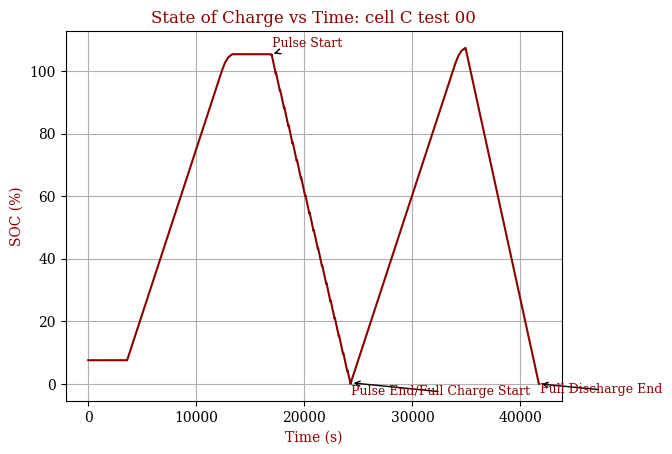

In [4]:
from plot import *

pt.plot_soc("C","00")


#### ***Analysis***

The **State of Charge (SoC) vs. Time graph** shows the charge and discharge behaviour of the ***cell "C"*** over the **test cycle "00"**. Initially, the SoC starts at a **low percentage** and gradually increases as the battery is charged. The overall pattern represents a controlled experimental setup designed to assess the battery’s response to repeated charge and discharge cycles. 

Once it reaches 100%, the battery undergoes a **series** of **charge and discharge cycles** before eventually reaching a full discharge at the end of the test. 

In the middle of the graph, we observe pulsed discharges, where the **SoC drops sharply** after reaching full charge. This pattern repeats, indicating that the battery is undergoing controlled pulse discharges. Such behaviour is common in battery characterization tests, particularly pulse current tests, which evaluate battery performance under **dynamic** conditions. These tests help assess **capacity retention**, **efficiency**, and the effects of **cycling** on battery health. 

At the end of the test, the SoC fully discharges to 0% and remains there, suggesting a **complete depletion** of the battery. This final discharge is the way we measure the battery’s total usable energy before recharge. 

---
## **State of Health** (SoH)

The State of Health (SoH) of batterries correspond to the ratio of the remaining capacity at a given time to the initial capacity. In other words, it shows how much capacity the battery has lost due to ageing. The SoH is expressed in percentage by the following equation:


$$
SoH [\%] = \frac{Q_{remaining}}{Q_{initial}}
$$


We decided to plot the SoH of cells C and D in function of their test value. Cell C has 23 tests, while cell D has 13. Test 00 is be the start of the experiment, meaning that the batteries are new in this test.


The following function ```plot_soh(cell)``` from the ```plot``` file takes ```"C"``` or ```"D"``` as argument. We plot the SoH of cell C:

In [ ]:
pt.plot_soh("C")


We get the following images:

<div align = "center">
    <img src = "img/soh_c.png" alt = "Image of SoH of Cell C in function of the tests" width = "575"/>
    <img src = "img/soh_d.png" alt = "Image of SoH of Cell D in function of the tests" width = "575"/>
</div>


## **Analysis of the State of Health (SoH) and Ageing Dynamics**

#### **General Decline Analysis of SoH for Cells C and D**

The SoH charts for Cells C and D display **agreeable degradation**, this behaviour is in alignment with lithium-ion battery nature. Under long-term testing, various chemical and structural ageing processes affect the cell's performance. 

Ageing of a cell is affected by various factors, including the accumulation of the **Solid Electrolyte Interphase (SEI)** layer, lithium corrosion, and the loss of active material on the Cathode and Anodes of a cell. The SEI sheet serves a pivotal role by streamlining lithium-ion (Li+) exchange between electrodes. It also intercepts electrons to prevent excessive electrolyte decay, and by doing so preserves the battery's chemical composition. As this SEI layer grows over time, it increases internal resistance and reduces battery efficiency.

As time goes on and the cell is used more and more, additional degradation processes affect it. The apparition of damage to the electrodes structure, alongside electrolyte decomposition, also contribute to the reduction of cell capacity. 

---

#### **Cell C (23 Test Intervals)**

- **Initial Phase (Tests 0 to ~10):**  

- **Middle Phase (~Test 10 to Test 14):**  

- **Later Phase (~Test 14 to Test 23):**  

---

#### **Cell D (13 Test Intervals)**

- **Initial Phase (Tests 0 to ~4):**  

- **Middle Phase (~Test 4 to Test 8):**  

- **Final Phase (~Test 9 to Test 13):**  

---

#### **Physical Interpretation of Degradation**

The degradation pattern observed make total sense when referring to the physical and chemical reactions occurring within lithium-ion cells:

1. **Early Phase (Stabilization):**  
   During the initial usage period, the SEI layer forms, which is beneficial for stabilizing the battery chemistry. However, it gradually consumes lithium ions, leading to a minor capacity loss.

2. **Middle Phase (Accelerated Ageing):**  
   As the battery undergoes more charge/discharge cycles, SEI thickening increases internal resistance, reducing energy efficiency. Lithium plating and further chemical side reactions could explain the increased degradation of the capacity. If this indeed occurs, the impedance growth limits charge transport, which ultimately contributes to a steeper decline in SoH. Given that the graphs consistently display a decrease in the tangent of their SoC, we can assume that this degradation is occurring inside the cells, as more and more tests are done.

3. **Last Phase (End-of-Life Characteristics):**  
   Once again the tangent SoC line decreases even more, even more electrolyte decomposition and chemical damage to the electrodes can be supposed. The pronounced and more abrupt decreases recorded may hint at widespread interior changes, as all the previously listed affects worsen. We could interpret this as the indication of the cell’s approach of its end-of-life (EoL) stage, though this interpretation remains speculative.



These complex ageing dynamics make it essential for Battery Management Systems (BMS) to accurately estimate SoH and manage battery usage efficiently. Accurate SoH estimation not only improves the charging/discharging process but also helps predict battery lifespan and optimize the operation of EVs and other energy storage systems.

As batteries age, it is expected that their capacity degrades due to chemical and structural changes inside the cells, leading to a decline in SoH.

--

## **EMC parameters as functions of SoC and SoH** 

### **EMC of order zero**

#### Finding $U_{OC}$

From the resource given, $U_{OC}$, or Open Circuit Voltage, is found when the battery has been at rest for a long enough time (1 or 2 hours). 
This translates graphically to finding the voltage of the battery when its current is equal to ```0 Amps```. For instance for cell D test 9, the circled portions of the graphs correspond to its OCV.

<div align = "center">
<img src = "img/finding_ocv.png" alt = "Finding OCV" width = "700"/>
</div>

Below is the code of the dataframe of cell D on test 9, where we keep the values such that its current is equal to ```0 Amps```.

In [ ]:
print(dt.find_OCV("D", "09")) # Dataframe with OCV extracted

print(dt.soc_ocv("D", "09")) # Dataframe with OCV extracted, and SoC calculated


However, since we can only measure the voltage after a pulse, we only get a sample of the OCV. So we can only establish a discrete relationship between the OCV and the SoC. 

To get its continuous version, we apply curve fitting thanks to the ```np.polyfit``` function.
We therefore have the following code:

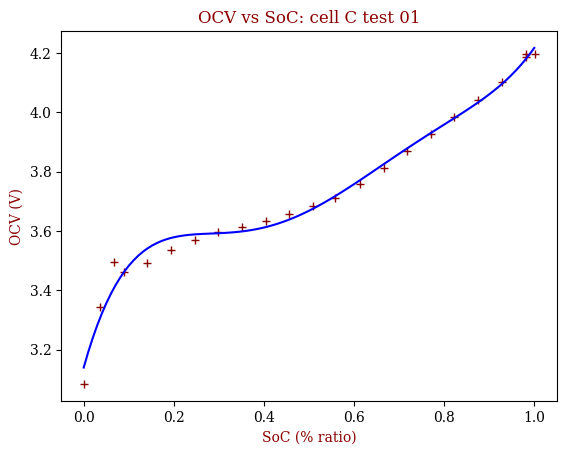

In [6]:
pt.model_data_soc_ocv("C", "01")


In [7]:
soc = dt.soc_ocv("D", "09")["SoC"] # Extract the OCV from the dataframe
ocv = dt.soc_ocv("D", "09")["OCV"] # Extract the SoC from the dataframe

# Fit a polynomial of degree 5
coefficients = np.polyfit(soc, ocv, 5) # Curve fitting the SoC in function of the OCV by a 5th degree polynomial 
polynomial = np.poly1d(coefficients) # Store the coefficients in the polynomial

# Thus, given an OCV, we can find the SoC by executing: polynomial(OCV)


NameError: name 'np' is not defined

So we finally get $U_{OC}$ in function of the SoC.

#### Finding $R_0$

Taking inspiration from the resource given, we establish the equation of the internal resistantce $R_0$ by:

$$
R_0 = \frac{U_A - U_B}{I_L}
$$

where $U_A$ and $U_B$ are found graphically. Below is an image of finding the four voltages per pulse.

<br>
<div align = "center">
<img src = "img/find_ua_ub_uc_ud.png" alt = "Finding UA UB UC UD" width = "700"/>
<p>Figure 1: Graph of the voltage during a current pulse. We can determine the voltages at points A, B and C</p>
<p>Source: Ruoyu Xu, "Lithium-ion battery modeling and SoC estimation", 2023 Kth Royal Institute of Technology, </p>
</div>
<br>
<br>

We observe that for each current pulse, the voltage follows a similar graph by zooming in. Below is an example of that of cell D on test 9. We observe that this pattern happens for a current pulse of around ```-30 Amps```.

<div align = "center">
<img src = "img/voltage_cell_d_test_9_49800s.png" alt = "Voltage after a current pulse of -30A" width = "900"/>
</div>

For each pulse, we get its associated SoC. Similarly for the $U_{OC}$, we only have a discrete relationship with the SoC. 
To get its continuous version, we apply curve fitting by executing the following code:

In [ ]:
soh_value = dt.soh("D","09")
#global soh_value
time_between_dupes = 300
df = dt.extract("D","09")
df["SoC"] = dt.soc("D","09")
df["R0"] = [dt.R0_fit.f(soc_value,soh_value) for soc_value in  dt.df["SoC"]]
print(df)


Knowing the two variables, we get the following simulation for the output voltage:

I am in the SOH function
I have Q remaining
I have q initial


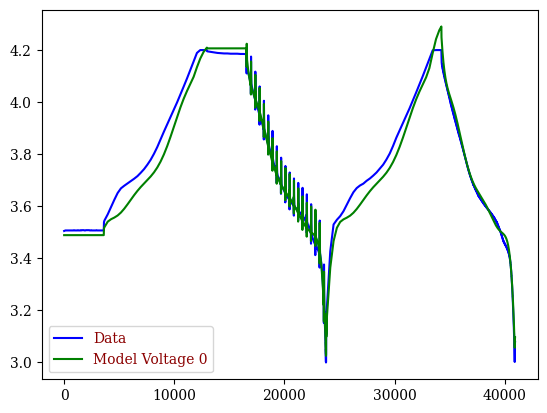

In [11]:
pt.plot_simultaneous_0("C", "09")


### **First order EMC**

$R_0$ and $U_{OC}$ are found using the results of the Rint Model. So we only need to determine $R_1$ and $C_1$.

#### Finding $R_1$

From the resource given, we get:

$$ R_1 = \frac{\mid U_C - U_B \mid}{I_L} $$

$U_C$ and $U_B$ are determined by finding the voltages during the current pulse of ```-30 Amps```. 

We finally apply curve fitting similarly to the startegies applied in the 0th order model.

#### Finding $\tau_1$


$\tau_1$ corresponds to the time at which the voltage reach 63% of the difference during the ```B-C``` phase of the pulse. Graphically, we have:

<div align = "center">
<img src = "img/find_tau.png" alt = "Image describing how to find tau" width = "900"/>
</div>

We apply curve fitting for a continuous relationship between $\tau_1$ and SoC.

The graph of the modelled output and that of the data given is found below

I am in the SOH function
I have Q remaining
I have q initial
I am in the SOH function
I have Q remaining
I have q initial
calculated model 0


c:\Users\akira\OneDrive\ドキュメント\Game Development\Python\EDF_Batteries\data.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split["R1"] = abs(split["Voltage"].iloc[0] -
c:\Users\akira\OneDrive\ドキュメント\Game Development\Python\EDF_Batteries\data.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split["R1"] = abs(split["Voltage"].iloc[0] -
c:\Users\akira\OneDrive\ドキュメント\Game Development\Python\EDF_Batteries\data.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

r1       Total Time  Current  Voltage  Step       SoC        R0       OCV  \
120      16968.3    -32.0    4.128     7  0.982137  0.001839  4.198739   
121      16969.3    -32.0    4.126     7  0.981841  0.001839  4.197820   
122      16970.3    -32.0    4.124     7  0.981544  0.001839  4.196906   
123      16971.3    -32.0    4.122     7  0.981248  0.001839  4.195997   
124      16972.3    -32.0    4.121     7  0.980952  0.001838  4.195093   
...          ...      ...      ...   ...       ...       ...       ...   
1277     23990.1    -32.0    3.239     7  0.034964  0.002590  3.335077   
1278     23991.1    -32.0    3.236     7  0.034668  0.002592  3.333609   
1279     23992.1    -32.0    3.233     7  0.034371  0.002595  3.332133   
1280     23993.1    -32.0    3.230     7  0.034075  0.002597  3.330648   
1281     23994.1    -32.0    3.227     7  0.033779  0.002600  3.329154   

            R1  
120   0.000405  
121   0.000404  
122   0.000403  
123   0.000402  
124   0.000401  
...   

c:\Users\akira\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8141    inf
8142    inf
8143   -inf
8144    NaN
8145    NaN
Length: 8146, dtype: float64
      Total Time  Current  Voltage  Step       SoC        R0       OCV  \
119      16967.3      0.0    4.185     6  0.982285  0.001839  4.199201   
120      16968.3    -32.0    4.128     7  0.982137  0.001839  4.198739   
121      16969.3    -32.0    4.126     7  0.981841  0.001839  4.197820   
122      16970.3    -32.0    4.124     7  0.981544  0.001839  4.196906   
123      16971.3    -32.0    4.122     7  0.981248  0.001839  4.195997   
...          ...      ...      ...   ...       ...       ...       ...   
1278     23991.1    -32.0    3.236     7  0.034668  0.002592  3.333609   
1279     23992.1    -32.0    3.233     7  0.034371  0.002595  3.332133   
1280     23993.1    -32.0    3.230     7  0.034075  0.002597  3.330648   
1281     23994.1    -32.0    3.227     7  0.033779  0.002600  3.329154   
1282     23995.2      0.0

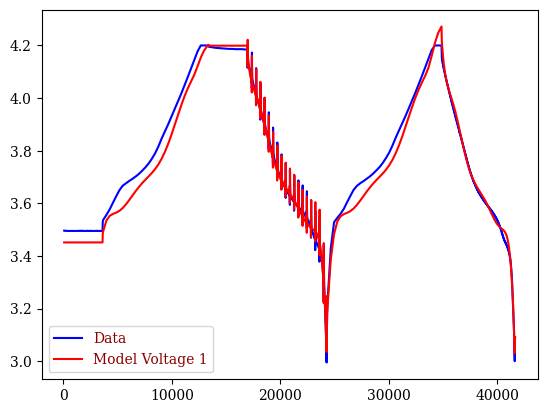

In [13]:
pt.plot_simultaneous_1("C", "01")
